### 0 Project

The aim of this project is to compare different methods of supervised learning algorithms to binary classification problem.

Data set contains over 28 thousands headlines divided into two class of sarcastic and non-sarcastic meaning - labelled with 0 and 1.

First step of analysis concentrate on cleaning data set and looking for some useful information.

Next we are using CountVectorizer, TFIDF and SVD to prepare data set to research on classification methods.

Comparison of 8 algorithms and some ideas on future ends this analysis.

Source of data set:

https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

rishabhmisra.github.io/publications


### 1. Libraries

Data analysis and computing

In [1]:
import pandas as pd
import numpy as np

Preprocess

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

Text mining

In [3]:
import re
import nltk
import string
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Machine learning

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

Measures

In [5]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix, roc_curve, auc

Visualisation

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

Others

In [7]:
np.random.seed(0)

from warnings import filterwarnings
filterwarnings("ignore")

### 2. Data Set

Loading Data Set with Headlines to analyse

In [8]:
FILENAME = 'Sarcasm_Headlines_Dataset.json'
Headlines_Dataset = pd.read_json(FILENAME, lines=True)

General information about data set

In [9]:
Headlines_Dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Number of Headlines

In [10]:
Headlines_Dataset.shape

(26709, 3)

Columns

In [11]:
Headlines_Dataset.columns

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')

In [12]:
Headlines_Dataset.drop(columns='article_link', inplace=True)

In [13]:
Headlines_Dataset.head(10)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
5,advancing the world's women,0
6,the fascinating case for eating lab-grown meat,0
7,"this ceo will send your kids to school, if you...",0
8,top snake handler leaves sinking huckabee camp...,1
9,friday's morning email: inside trump's presser...,0


Checking number of instances in each class

In [14]:
Headlines_Dataset.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [15]:
Headlines_Dataset.is_sarcastic.value_counts()/Headlines_Dataset.is_sarcastic.value_counts().sum()

0    0.561047
1    0.438953
Name: is_sarcastic, dtype: float64

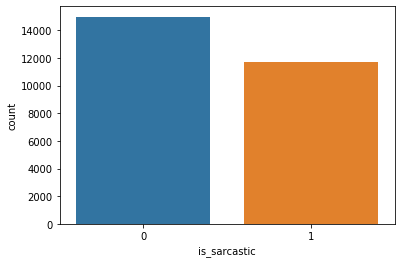

In [16]:
sns.countplot(Headlines_Dataset.is_sarcastic)
plt.show()

Data set is balanced

### 3. Data Cleaning

Changing all headlines to lower case form

In [17]:
Headlines_Dataset.headline = [single_headline.lower() for single_headline in Headlines_Dataset.headline]

Before we clean all headlines from digits and non-letter symbols we need to look inside our data. Maybe there are some information worth not to lose

In [18]:
for single_headline in Headlines_Dataset.headline[:15]:
    print(single_headline)

former versace store clerk sues over secret 'black code' for minority shoppers
the 'roseanne' revival catches up to our thorny political mood, for better and worse
mom starting to fear son's web series closest thing she will have to grandchild
boehner just wants wife to listen, not come up with alternative debt-reduction ideas
j.k. rowling wishes snape happy birthday in the most magical way
advancing the world's women
the fascinating case for eating lab-grown meat
this ceo will send your kids to school, if you work for his company
top snake handler leaves sinking huckabee campaign
friday's morning email: inside trump's presser for the ages
airline passengers tackle man who rushes cockpit in bomb threat
facebook reportedly working on healthcare features and apps
north korea praises trump and urges us voters to reject 'dull hillary'
actually, cnn's jeffrey lord has been 'indefensible' for a while
barcelona holds huge protest in support of refugees


Let's keep some information about occurence of digits and few chosen marks

In [19]:
Headlines_Dataset['is_question_mark'] = Headlines_Dataset.headline.apply(lambda x: int(len(re.findall("\?", x)) > 0))
Headlines_Dataset['is_exclamation_mark'] = Headlines_Dataset.headline.apply(lambda x: int(len(re.findall("\!", x)) > 0))
Headlines_Dataset['is_percent_mark'] = Headlines_Dataset.headline.apply(lambda x: int(len(re.findall("\%", x)) > 0))
Headlines_Dataset['is_digit'] = Headlines_Dataset.headline.apply(lambda x: int(len(re.findall("\d+", x)) > 0))

Deleting all digits

In [20]:
print(string.digits)
digits_map = str.maketrans({key: None for key in string.digits})

0123456789


In [21]:
Headlines_Dataset.headline = [single_headline.translate(digits_map) for single_headline in Headlines_Dataset.headline]

Number of used punctuation

In [22]:
def punctuation_number(headline):
    return(len([word for word in headline.split() if word in list(string.punctuation)]))

Headlines_Dataset['number_of_punctuation'] = Headlines_Dataset.headline.apply(lambda x: punctuation_number(x))

Deleting all punctuations and special symbols

In [23]:
print(string.punctuation)
punct_map = str.maketrans({key: None for key in string.punctuation})

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [24]:
Headlines_Dataset.headline = [single_headline.translate(punct_map) for single_headline in Headlines_Dataset.headline]

Information about number of words, number of letters and length of words

In [25]:
Headlines_Dataset['number_of_words'] = Headlines_Dataset.headline.apply(lambda x: len(x.split()))

In [26]:
Headlines_Dataset['number_of_unique_words'] = Headlines_Dataset.headline.apply(lambda x: len(set(x.split())))

In [27]:
Headlines_Dataset['number_of_letters'] = Headlines_Dataset.headline.apply(lambda x: len(x))

In [28]:
def average_len_word(headline):
    return(np.mean([len(word) for word in headline.split()]))

Headlines_Dataset['avg_len_word'] = Headlines_Dataset.headline.apply(lambda x: average_len_word(x))

Tokenization

In [29]:
Headlines_Dataset.headline = [nltk.word_tokenize(single_headline) for single_headline in Headlines_Dataset.headline]

Number of used stopwords

In [30]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords[:15]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours']

In [31]:
def number_of_stopwords(headline):
    return(len([word for word in headline if word in stopwords]))

Headlines_Dataset['number_of_stopwords'] = Headlines_Dataset.headline.apply(lambda x: number_of_stopwords(x))

Deleting stopwords

In [32]:
Headlines_Dataset.headline = [[word for word in single_headline if word not in stopwords] for single_headline in Headlines_Dataset.headline]

Stemming

In [33]:
stemmer = nltk.PorterStemmer()
Headlines_Dataset.headline = [[stemmer.stem(word) for word in headline] for headline in Headlines_Dataset.headline]

Join headlines word list into single headline

In [34]:
Headlines_Dataset.headline = [" ".join(headline) for headline in Headlines_Dataset.headline]

Looking at data set after cleaning

In [35]:
Headlines_Dataset.head(10)

,headline,is_sarcastic,is_question_mark,is_exclamation_mark,is_percent_mark,is_digit,number_of_punctuation,number_of_words,number_of_unique_words,number_of_letters,avg_len_word,number_of_stopwords
0,former versac store clerk sue secret black cod...,0,0,0,0,0,0,12,12,76,5.416667,2
1,roseann reviv catch thorni polit mood better wors,0,0,0,0,0,0,14,14,81,4.857143,6
2,mom start fear son web seri closest thing gran...,1,0,0,0,0,0,14,13,78,4.642857,5
3,boehner want wife listen come altern debtreduc...,1,0,0,0,0,0,13,13,82,5.384615,5
4,jk rowl wish snape happi birthday magic way,0,0,0,0,0,0,11,11,62,4.727273,3
5,advanc world women,0,0,0,0,0,0,4,4,26,5.750000,1
6,fascin case eat labgrown meat,0,0,0,0,0,0,7,7,45,5.571429,2
7,ceo send kid school work compani,0,0,0,0,0,0,14,14,66,3.785714,8
8,top snake handler leav sink huckabe campaign,1,0,0,0,0,0,7,7,50,6.285714,0
9,friday morn email insid trump presser age,0,0,0,0,0,0,9,9,56,5.333333,2


### 4. Text representation

After cleaning data set we can look into number of each word occurence in all headlines. We can compare our two class - sarcastic and non-sarcastic headlines according to this element

#### CountVectorizer

In [36]:
min_number_of_occurence = 3

cv = CountVectorizer(min_df = min_number_of_occurence)
Headlines_CountVec = cv.fit_transform(Headlines_Dataset.headline)

CountVectorizer returns sparse matrix

In [37]:
Headlines_CountVec.todense().A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
Headlines_CountVec.shape

(26709, 7678)

In [39]:
#cv.vocabulary_

In [40]:
cv.get_feature_names()[:15]

['aaron',
 'aarp',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abc',
 'abduct',
 'abdul',
 'abil',
 'abl',
 'aboard',
 'abort',
 'abram',
 'abramson']

In [41]:
Headlines_CountVec_Dense = pd.DataFrame(Headlines_CountVec.toarray(), columns=cv.get_feature_names())
Headlines_CountVec_Dense.head(10)

,aaron,aarp,ab,abandon,abbey,abbi,abc,abduct,abdul,abil,...,zealand,zen,zero,zika,zimmerman,zip,zone,zoo,zookeep,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


List of top 20 most frequent words:

In [42]:
most_freq_words = 20

Headlines_CountVec_Dense.sum().sort_values(ascending=False)[:most_freq_words]

trump       1650
new         1516
man         1386
get          770
say          697
report       668
make         621
us           568
day          535
one          535
year         523
nation       504
time         495
american     494
area         492
woman        479
donald       473
like         472
obama        426
take         415
dtype: int64

Merging data set created with CountVectorizer and data set with information about number o words and letters in headline

In [43]:
Headlines = pd.merge(Headlines_Dataset, Headlines_CountVec_Dense, left_index=True, right_index=True)

In [44]:
Headlines.shape

(26709, 7690)

In [45]:
Headlines.drop(columns='headline', inplace=True)

In [46]:
Headlines.columns

Index(['is_sarcastic', 'is_question_mark', 'is_exclamation_mark',
       'is_percent_mark', 'is_digit', 'number_of_punctuation',
       'number_of_words', 'number_of_unique_words', 'number_of_letters',
       'avg_len_word',
       ...
       'zealand', 'zen', 'zero', 'zika', 'zimmerman', 'zip', 'zone', 'zoo',
       'zookeep', 'zuckerberg'],
      dtype='object', length=7689)

In [47]:
Headlines.head(10)

,is_sarcastic,is_question_mark,is_exclamation_mark,is_percent_mark,is_digit,number_of_punctuation,number_of_words,number_of_unique_words,number_of_letters,avg_len_word,...,zealand,zen,zero,zika,zimmerman,zip,zone,zoo,zookeep,zuckerberg
0,0,0,0,0,0,0,12,12,76,5.416667,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,14,14,81,4.857143,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,14,13,78,4.642857,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,13,13,82,5.384615,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,11,11,62,4.727273,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,4,4,26,5.750000,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,7,7,45,5.571429,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,14,14,66,3.785714,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,7,7,50,6.285714,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,9,9,56,5.333333,...,0,0,0,0,0,0,0,0,0,0


Most frequent words in sarcastic headlines:

In [48]:
most_freq_words = 20

Headlines_CountVec_Dense[Headlines['is_sarcastic'] == 1].sum().sort_values(ascending=False)[:most_freq_words]

man         1148
new          839
report       504
area         479
nation       403
get          393
woman        319
american     273
day          271
one          271
time         268
find         247
make         241
trump        235
year         235
go           233
like         230
studi        216
us           213
still        209
dtype: int64

Most frequent words in non-sarcastic headlines:

In [49]:
most_freq_words = 20

Headlines_CountVec_Dense[Headlines['is_sarcastic'] == 0].sum().sort_values(ascending=False)[:most_freq_words]

trump     1415
new        677
say        519
donald     457
make       380
get        377
us         355
women      313
year       288
day        264
one        264
way        255
show       252
peopl      243
like       242
world      239
obama      239
man        238
want       233
thing      230
dtype: int64

### 5. Machine Learning

#### 5.1 CountVectorizer

Preparing data for supervised learning algorithms

In [113]:
X_train, X_test, y_train, y_test = train_test_split(Headlines.drop(columns='is_sarcastic'), Headlines[['is_sarcastic']], test_size=0.3, random_state=42)

Checking class ratio in train/test sets:

In [51]:
y_train.is_sarcastic.value_counts()/y_train.is_sarcastic.value_counts().sum()

0    0.56381
1    0.43619
Name: is_sarcastic, dtype: float64

In [52]:
y_test.is_sarcastic.value_counts()/y_test.is_sarcastic.value_counts().sum()

0    0.554599
1    0.445401
Name: is_sarcastic, dtype: float64

#### SVD

As we can see our data set have over 7 thousands features - it can be troublesome for machine learning algorithms. 
In this situation we can use some dimensonality reduction methods to decrease number of features, but we have to keep in mind not to lose too much information

In [53]:
number_of_components = 20
svd = TruncatedSVD(n_components = number_of_components)
X_train_svd = svd.fit_transform(X_train)
X_train_svd.shape

(18696, 20)

In [54]:
svd.explained_variance_ratio_.cumsum()

array([0.95951397, 0.97480773, 0.98038219, 0.98248887, 0.98283917,
       0.98305405, 0.98322839, 0.98337484, 0.98350118, 0.98358534,
       0.98366123, 0.9837351 , 0.98380247, 0.98386502, 0.98392627,
       0.98398263, 0.98403763, 0.98408937, 0.98414026, 0.98419028])

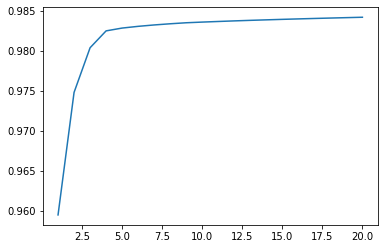

In [55]:
plt.plot(np.arange(1, number_of_components+1), svd.explained_variance_ratio_.cumsum())
plt.show()

Suprisingly, even only 2 components of singular value decomposition explains over 97% of dataset variance. As we see on plot - above 4 compononets there is extremaly slowly growth of cumulated explained variance

#### CountVectorizer + SVD Classification

Now we will check how different machine learning algorithms solve our classification problem.

Data set was preprocessed with CountVectorizer and SVD was used to reduce dimensionality

In [114]:
number_of_components = 20
svd = TruncatedSVD(n_components = number_of_components)
X_train_svd = svd.fit_transform(X_train)

In [115]:
X_test_svd = svd.transform(X_test)

In [58]:
pipelines = [Pipeline([("scaler", StandardScaler()), ("LR", LogisticRegression())]),
             Pipeline([("scaler", StandardScaler()), ("KNN", KNeighborsClassifier())]),
             Pipeline([("scaler", StandardScaler()), ("DT", DecisionTreeClassifier())]),
             Pipeline([("scaler", StandardScaler()), ("RF", RandomForestClassifier())]),
             Pipeline([("scaler", StandardScaler()), ("ET", ExtraTreesClassifier())]),
             Pipeline([("scaler", StandardScaler()), ("NN_log", MLPClassifier(solver='lbfgs', activation = 'logistic'))]),
             Pipeline([("scaler", StandardScaler()), ("NN_relu", MLPClassifier(solver='lbfgs', activation = 'relu'))]),
             Pipeline([("scaler", StandardScaler()), ("AdaBoost", AdaBoostClassifier())])]

param_grids = [{"LR__penalty": ["l2", 'none'],
                "LR__C": [1000, 100, 10, 1, 0.1, 0.01]},
               {'KNN__n_neighbors': [2, 3, 5, 10]},
               {'DT__min_samples_leaf': [5, 10, 25, 50],
                'DT__max_depth': [None, 30, 20, 10]},
               {'RF__n_estimators': [50, 100, 150],
                'RF__min_samples_leaf': [1, 2, 5],
                'RF__max_depth': [None, 10, 50],
                'RF__min_samples_split': [2, 5]},
               {'ET__n_estimators': [50, 100, 150],
                'ET__min_samples_leaf': [1, 2, 5],
                'ET__max_depth': [None, 10, 50],
                'ET__min_samples_split': [2, 5]},
               {},
               {},
               {'AdaBoost__n_estimators': [10, 25, 50, 100]}
              ]

In [59]:
results_count_vec_svd = []

for model, grid in zip(pipelines, param_grids):
    gs = GridSearchCV(model, grid, cv=5, n_jobs=-1, verbose=1)
    gs.fit(X_train_svd, y_train)
    
    results_count_vec_svd.append({'model': model.get_params()['steps'][1][0],
                                  'accuracy_score': accuracy_score(y_test, gs.predict(X_test_svd)),
                                  'f1_score': f1_score(y_test, gs.predict(X_test_svd)),
                                  'precision_score': accuracy_score(y_test, gs.predict(X_test_svd)),
                                  'recall_score': f1_score(y_test, gs.predict(X_test_svd))})

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.1s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.1s finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 11.5min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.9s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.0s finished


In [60]:
pd.DataFrame(results_count_vec_svd)

,model,accuracy_score,f1_score,precision_score,recall_score
0,LR,0.668164,0.588071,0.668164,0.588071
1,KNN,0.667790,0.579463,0.667790,0.579463
2,DT,0.683140,0.632402,0.683140,0.632402
3,RF,0.719955,0.664373,0.719955,0.664373
4,ET,0.716336,0.661907,0.716336,0.661907
5,NN_log,0.730688,0.690121,0.730688,0.690121
6,NN_relu,0.720329,0.676763,0.720329,0.676763
7,AdaBoost,0.707850,0.652103,0.707850,0.652103


As we can see there are significantly differences in results of all algorithms. Both MLP Classifiers reached best result, also Random Forest Classifier, ExtraTree Classifier and Adaboost have accuracy on test set above 70%.

#### 5.2 TFIDF

Now let's check results of 5 best algorithms from previous comparison - on data set prepared with TFIDF and SVD.We have to back to data set Headlines_Dataset - after text cleaning, but before Count Vectorizer.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(Headlines_Dataset.drop(columns='is_sarcastic'), Headlines_Dataset[['is_sarcastic']], test_size=0.3, random_state=42)

In [106]:
min_number_of_occurence = 3

tfidf = TfidfVectorizer(min_df=min_number_of_occurence)
X_train_TFIDF = tfidf.fit_transform(X_train.headline)

In [107]:
X_train_TFIDF_Dense = pd.DataFrame(X_train_TFIDF.toarray(), columns=tfidf.get_feature_names())
X_train_TFIDF_Full = pd.merge(Headlines_Dataset, X_train_TFIDF_Dense, left_index=True, right_index=True)
X_train_TFIDF_Full.drop(columns='headline', inplace=True)
print(X_train_TFIDF_Full.shape)

(18696, 6240)


In [108]:
X_test_TFIDF = tfidf.transform(X_test.headline)
X_test_TFIDF_Dense = pd.DataFrame(X_test_TFIDF.toarray(), columns=tfidf.get_feature_names())
X_test_TFIDF_Full = pd.merge(Headlines_Dataset, X_test_TFIDF_Dense, left_index=True, right_index=True)
X_test_TFIDF_Full.drop(columns='headline', inplace=True)
print(X_test_TFIDF_Full.shape)

(8013, 6240)


SVD:

In [109]:
number_of_components = 20
svd = TruncatedSVD(n_components = number_of_components)
X_train_tfidf_svd = svd.fit_transform(X_train_TFIDF_Full)

In [110]:
svd.explained_variance_ratio_.cumsum()

array([0.97288226, 0.9883156 , 0.99395534, 0.99606572, 0.99667043,
       0.99701511, 0.99722164, 0.99730404, 0.9973776 , 0.99739443,
       0.99740657, 0.99741637, 0.99742516, 0.99743281, 0.99743852,
       0.99744386, 0.997449  , 0.99745391, 0.99745869, 0.99746333])

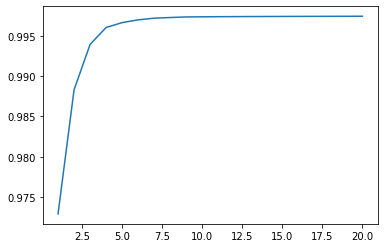

In [111]:
plt.plot(np.arange(1, number_of_components+1), svd.explained_variance_ratio_.cumsum())
plt.show()

In [80]:
X_test_tfidf_svd = svd.transform(X_test_TFIDF_Full)

In [86]:
pipelines = [Pipeline([("scaler", StandardScaler()), ("RF", RandomForestClassifier())]),
             Pipeline([("scaler", StandardScaler()), ("ET", ExtraTreesClassifier())]),
             Pipeline([("scaler", StandardScaler()), ("NN_log", MLPClassifier(solver='lbfgs', activation = 'logistic'))]),
             Pipeline([("scaler", StandardScaler()), ("NN_relu", MLPClassifier(solver='lbfgs', activation = 'relu'))]),
             Pipeline([("scaler", StandardScaler()), ("AdaBoost", AdaBoostClassifier())])]

param_grids = [{'RF__n_estimators': [50, 100, 150],
                'RF__min_samples_leaf': [1, 2, 5],
                'RF__max_depth': [None, 10, 50],
                'RF__min_samples_split': [2, 5]},
               {'ET__n_estimators': [50, 100, 150],
                'ET__min_samples_leaf': [1, 2, 5],
                'ET__max_depth': [None, 10, 50],
                'ET__min_samples_split': [2, 5]},
               {},
               {},
               {'AdaBoost__n_estimators': [10, 25, 50, 100]}
              ]

In [87]:
results_tfidf_svd = []

for model, grid in zip(pipelines, param_grids):
    gs = GridSearchCV(model, grid, cv=5, n_jobs=-1, verbose=1)
    gs.fit(X_train_tfidf_svd, y_train)
    
    results_tfidf_svd.append({'model': model.get_params()['steps'][1][0],
                              'accuracy_score': accuracy_score(y_test, gs.predict(X_test_tfidf_svd)),
                              'f1_score': f1_score(y_test, gs.predict(X_test_tfidf_svd)),
                              'precision_score': accuracy_score(y_test, gs.predict(X_test_tfidf_svd)),
                              'recall_score': f1_score(y_test, gs.predict(X_test_tfidf_svd))})

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 12.6min finished


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  4.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.2s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.7s finished


In [112]:
pd.DataFrame(results_tfidf_svd)

,model,accuracy_score,f1_score,precision_score,recall_score
0,RF,0.670161,0.560599,0.670161,0.560599
1,ET,0.655809,0.531590,0.655809,0.531590
2,NN_log,0.650069,0.561052,0.650069,0.561052
3,NN_relu,0.635842,0.553139,0.635842,0.553139
4,AdaBoost,0.642830,0.502952,0.642830,0.502952


As we can see results with TFIDF are worse. Every model has lower values of accuracy and other masures

### 6. Summary

In [116]:
pd.DataFrame(results_count_vec_svd)

,model,accuracy_score,f1_score,precision_score,recall_score
0,LR,0.668164,0.588071,0.668164,0.588071
1,KNN,0.667790,0.579463,0.667790,0.579463
2,DT,0.683140,0.632402,0.683140,0.632402
3,RF,0.719955,0.664373,0.719955,0.664373
4,ET,0.716336,0.661907,0.716336,0.661907
5,NN_log,0.730688,0.690121,0.730688,0.690121
6,NN_relu,0.720329,0.676763,0.720329,0.676763
7,AdaBoost,0.707850,0.652103,0.707850,0.652103


In our analysis the best results reached MLP Classifier and Random Forrest Classifier and Extra Tree Classifier with Count Vectorizer and SVD. Best accuracy is 73%.

Next step should be comparison of more sofisticated models of Neural Networks, because quite good results from MLP Classifier show us some direction to further research.

What will bring huge value added to this work is optimize code to Object Oriented Programing structures - it will shorten time of computing and make everything much cleaner.